# Project 3: Web APIs & NLP

## Problem Statement

Many times, advertisers want to target their marketing to customers that will purchase their product. That is why, if someone is selling a book, they would be interested in showing a book ad to someone who is already talking about books. The data science problem answered in this project is whether or not subreddit titles and self text are predictive of the subreddit "movies" and "books" topics. To approach this problem, I leveraged the Pushshift API and NLP to train binary classifiers.

## Executive Summary

Both the Logistic Regression and Multinomial Naive Bayes models provided good outputs. Though the model shows high variance, as can be seen from the higher train than test score, the model is able to predict whether a document is coming from a Movies subreddit or a Books subreddit with good accuracy. Limiting the number of features or adding regulation would reduce variance, but also decrease the accuracy of the model.

## Contents

- [Data Gathering](#Data-Gathering)
- [EDA](#EDA)
- [Models](#Models)
- [Results](#Results)
- [Conclusion](#Conclusion)

# Data Gathering

Import libraries

In [1]:
import pandas as pd
import datetime as dt
import time
import requests
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

Using Pushshift API, The pushshift.io Reddit API was designed to help provide enhanced functionality and search capabilities for searching Reddit comments and submissions

In [2]:
# code from project 3 intro
def query_pushshift(subreddit, kind = 'submission', day_window = 7, n = 5):
    SUBFIELDS = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self']
    
    # BASE_URL & Parameters
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}" # also known as the "API endpoint" 
    size = 500
      
    # instantiate empty list for temp storage
    posts = []
    
    # implement for loop with `time.sleep(2)`
    for i in range(1, n + 1):
        response = requests.get(BASE_URL,
                                params = {
                                    'subreddit': subreddit,
                                    'size': size,
                                    'after': f'{day_window*i}d'
                                })
        print(f'Getting data from subreddit {subreddit} after {day_window*i} days')
        assert response.status_code == 200, 'Check url'
        json = response.json()['data']
        df = pd.DataFrame.from_dict(json)
        posts.append(df)
        time.sleep(2)
    
    # pd.concat storage list
    full = pd.concat(posts, sort=False)
    
    # if submission
    if kind == "submission":
        # select desired columns
        full = full[SUBFIELDS]
        # drop duplicates
        full.drop_duplicates(inplace = True)
        # select `is_self` == True
        full = full.loc[full['is_self'] == True]

    # create `timestamp` column
    full['timestamp'] = full["created_utc"].map(dt.date.fromtimestamp)
    
    print("Query Complete!")    
    return full 

Getting results for movies and books

In [3]:
results_movies = query_pushshift("movies")

Getting data from subreddit movies after 7 days
Getting data from subreddit movies after 14 days
Getting data from subreddit movies after 21 days
Getting data from subreddit movies after 28 days
Getting data from subreddit movies after 35 days
Query Complete!


In [4]:
results_books = query_pushshift("books")

Getting data from subreddit books after 7 days
Getting data from subreddit books after 14 days
Getting data from subreddit books after 21 days
Getting data from subreddit books after 28 days
Getting data from subreddit books after 35 days
Query Complete!


# EDA

Checking data shape, null values, graphing, and more!

In [5]:
# movie shape
movies = results_movies.shape
movies

(1093, 9)

In [6]:
# books shape
books = results_books.shape
books

(2027, 9)

In [7]:
# null values in movies data
results_movies['selftext'].isnull().sum()/movies[0]

0.04940530649588289

In [8]:
# null values in books data
results_books['selftext'].isnull().sum()/books[0]

0.06610754810064134

In [9]:
# remove null values
results_movies = results_movies[results_movies['selftext'].notnull()]
results_books = results_books[results_books['selftext'].notnull()]

In [10]:
# new movie shape
results_movies.shape

(1039, 9)

In [11]:
# new movie shape
results_books.shape

(1893, 9)

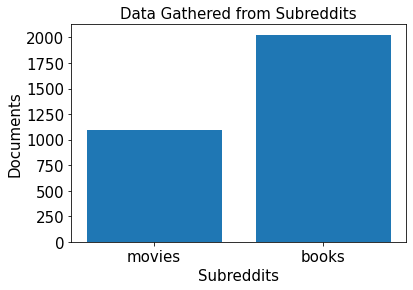

In [12]:
# plot number of documents for each category
plt.bar(['movies', 'books'], [movies[0], books[0]])
plt.xlabel("Subreddits", fontsize= 15)
plt.ylabel("Documents", fontsize= 15)
plt.title("Data Gathered from Subreddits", fontsize=15)
plt.xticks(fontsize= 15)
plt.yticks(fontsize= 15);

In [13]:
# scaling down data to have a balanced dataset
results_books_scaled = results_books.copy().sample(frac = 0.54)
results_books_scaled.shape

(1022, 9)

In [14]:
# concatenating data from Movies and Books
frames = [results_movies, results_books_scaled]
df = pd.concat(frames)

In [15]:
# reset index
df.reset_index(drop = True, inplace = True) 

In [16]:
# checking value counts
df['subreddit'].value_counts()

movies    1039
books     1022
Name: subreddit, dtype: int64

In [17]:
# checking baseline model
df['subreddit'].value_counts(normalize = True)

movies    0.504124
books     0.495876
Name: subreddit, dtype: float64

In [18]:
# changing subreddit so that books = 1 and movies = 0
df['subreddit'] = df['subreddit'].map({'books': 1, 'movies': 0})

In [19]:
# checking counts didn't change
df['subreddit'].value_counts()

0    1039
1    1022
Name: subreddit, dtype: int64

In [20]:
# displaying data, notice both title and selftext contain text
df.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Are there any actual movies out there with *FR...,[removed],0,1587655617,JackingOffAcc,1,1,True,2020-04-23
1,seek a sub pet to train with the urge and will...,[removed],0,1587655823,lindabarr147,0,1,True,2020-04-23
2,Live Thread - Avengers: Endgame [SPOILERS],[removed],0,1587656073,AdrienSergent,0,1,True,2020-04-23
3,Are movie theaters *ever* coming back?,"Please, somebody convince me that I'm stupid f...",0,1587656322,InspectorMendel,57,1,True,2020-04-23
4,Blue Movie App - Watch Unlimited Movies 100% Free,[removed],0,1587656585,hasnainbajwa92,0,1,True,2020-04-23


In [21]:
# this function will help visualize the top words with highest frequency
def top_words(corpus, ngram, stop_w):

   # https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
    vect = CountVectorizer (ngram_range = ngram , stop_words = stop_w)
    vec = vect.fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [[word, sum_words[0, idx]] for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    words = [word for word, count in words_freq]
    count = [count for word, count in words_freq]
    
    plt.figure(figsize=(9, 9))
    plt.barh(words[:20], count[:20])
    plt.xlabel("Frequency", fontsize= 15)
    plt.ylabel("Word", fontsize= 15)
    plt.title("Word Frequency", fontsize=25)
    plt.xticks(fontsize= 15)
    plt.yticks(fontsize= 15);

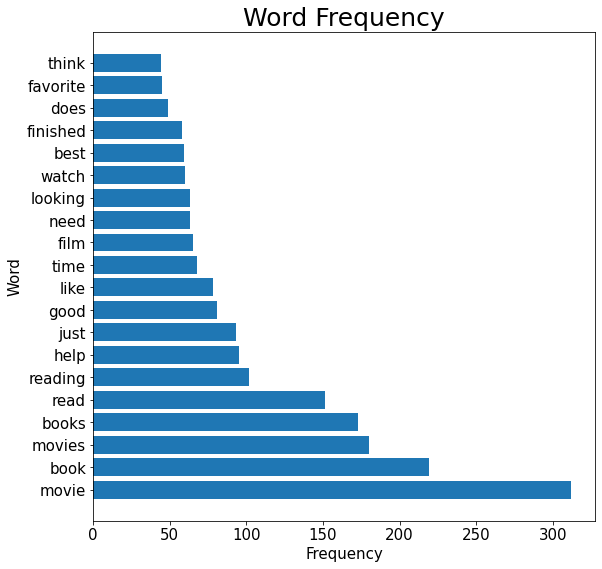

In [22]:
# looking at the "title" feature
top_words(df['title'], ngram = (1,2), stop_w = 'english')

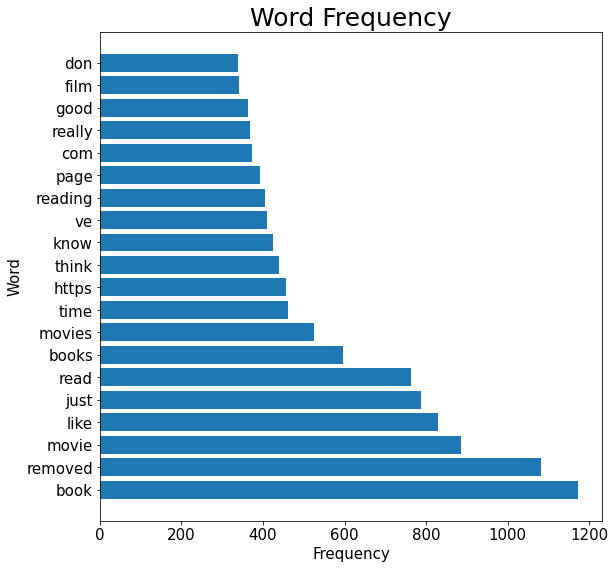

In [23]:
# Concatenating the "title" column with the "selftext" column
top_words(df['title'] + " " + df['selftext'], ngram = (1,2), stop_w = 'english')

# Models

The models I chose are Logistic Regression, Multinomial Naive Bayes, and also checked a Decision Tree Classifier

In [24]:
# I will use the concatenated column that includes both the text in the title column as well as the self text column
X = df['title'] + " " + df['selftext']
y = df['subreddit']
# X = df['title'] was not used since it provided lower scores

# Split into train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)


In [25]:
X_train.shape[0]/X.shape[0]

0.7496360989810772

Logistic Regression

In [26]:
def grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), ngram = [(1,1), (2,2), (1,2)],
                       stop_w = ['english'], penalty = ['none', 'l2'], c = [0.2,0.5, 1,2,3], m_iter = [1000], max_d = [1.0], min_d = [1], max_f = [None], accents = [None]):
    
    # Define Pipeline - Remeber the step structure (list of tuple)
    pipe = Pipeline(steps = [('vectorizer', vectorizer),
                             ('model', LogisticRegression())
                              ])

    # Construct Grid Parameters
    hyperparams = {'vectorizer__ngram_range': ngram,
                   'vectorizer__stop_words': stop_w,
                   'vectorizer__max_df': max_d,
                   'vectorizer__min_df': min_d,
                   'vectorizer__max_features': max_f,
                   'vectorizer__strip_accents': accents,
                   'model__penalty': penalty,
                   'model__C': c,
                   'model__max_iter': m_iter
                  }

    # Perform Grid Search
    lr = GridSearchCV(pipe,
                     param_grid = hyperparams,
                     cv = 3,
                     scoring = 'accuracy')

    results = lr.fit(X_train, y_train)
    
    # Get score
    train_score = results.best_score_
    print('Best crossval score: {:.4f}'.format(train_score))
    train_score = results.score(X_train, y_train)
    print('Best TRAIN score: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST score: {:.4f}'.format(test_score))
    print(results.best_params_)

    
    return lr

Multinomial Naive Bayes

In [27]:
def grid_search_reddit_nb(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), ngram = [(1,1), (2,2), (1,2)],
                       stop_words = [None, 'english'], max_f = [None], min_d= [1], max_d=[.98, .99, .97, 1, 1.0]):
    
    # Define Pipeline - Remeber the step structure (list of tuple)
    pipe = Pipeline(steps = [('vectorizer', vectorizer),
                             ('model', MultinomialNB())
                              ])

    # Construct Grid Parameters
    hyperparams = {'vectorizer__ngram_range': ngram,
                   'vectorizer__stop_words': stop_words,
                   'vectorizer__max_features': max_f,
                   'vectorizer__min_df': min_d,
                   'vectorizer__max_df': max_d
                  }

    # Perform Grid Search
    nb = GridSearchCV(pipe,
                     param_grid = hyperparams,
                     cv = 3,
                     scoring = 'accuracy')

    results = nb.fit(X_train, y_train)
                             
    # Get score
    train_score = results.best_score_
    print('Best crossval score: {:.4f}'.format(train_score))
    train_score = results.score(X_train, y_train)
    print('Best TRAIN score: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST score: {:.4f}'.format(test_score))
    print(results.best_params_)
    
    return nb


Decision Tree Classifier

In [28]:
def grid_search_reddit_tree(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), ngram = [(1,1), (2,2), (1,2)],
                       stop_w = ['english'], penalty = ['none', 'l2'], C = [1, 3, 10, 1000], m_iter = [1000]):
    
    # Define Pipeline - Remeber the step structure (list of tuple)
    pipe = Pipeline(steps = [('vectorizer', vectorizer),
                             ('model', DecisionTreeClassifier())
                              ])

    # Construct Grid Parameters
    hyperparams = {'vectorizer__ngram_range': ngram,
                   'vectorizer__stop_words': stop_w, 
                  }

    # Perform Grid Search
    dt = GridSearchCV(pipe,
                     param_grid = hyperparams,
                     cv = 3,
                     scoring = 'accuracy')

    results = dt.fit(X_train, y_train)
                             
    # Get score
    train_score = results.best_score_
    print('Best crossval score: {:.4f}'.format(train_score))
    train_score = results.score(X_train, y_train)
    print('Best TRAIN score: {:.4f}'.format(train_score))
    test_score = results.score(X_test, y_test)
    print('Best TEST score: {:.4f}'.format(test_score))
    print(results.best_params_)

    
    return dt

# Results

In [29]:
# created a list of words where I added different words to the 'english' stopwords to check performance
list_of_words = ['removed',
                 'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides',
           'between',
           'beyond',
           'bill',
           'both',
           'bottom',
           'but',
           'by',
           'call',
           'can',
           'cannot',
           'cant',
           'co',
           'con',
           'could',
           'couldnt',
           'cry',
           'de',
           'describe',
           'detail',
           'do',
           'done',
           'down',
           'due',
           'during',
           'each',
           'eg',
           'eight',
           'either',
           'eleven',
           'else',
           'elsewhere',
           'empty',
           'enough',
           'etc',
           'even',
           'ever',
           'every',
           'everyone',
           'everything',
           'everywhere',
           'except',
           'few',
           'fifteen',
           'fifty',
           'fill',
           'find',
           'fire',
           'first',
           'five',
           'for',
           'former',
           'formerly',
           'forty',
           'found',
           'four',
           'from',
           'front',
           'full',
           'further',
           'get',
           'give',
           'go',
           'had',
           'has',
           'hasnt',
           'have',
           'he',
           'hence',
           'her',
           'here',
           'hereafter',
           'hereby',
           'herein',
           'hereupon',
           'hers',
           'herself',
           'him',
           'himself',
           'his',
           'how',
           'however',
           'hundred',
           'i',
           'ie',
           'if',
           'in',
           'inc',
           'indeed',
           'interest',
           'into',
           'is',
           'it',
           'its',
           'itself',
           'keep',
           'last',
           'latter',
           'latterly',
           'least',
           'less',
           'ltd',
           'made',
           'many',
           'may',
           'me',
           'meanwhile',
           'might',
           'mill',
           'mine',
           'more',
           'moreover',
           'most',
           'mostly',
           'move',
           'much',
           'must',
           'my',
           'myself',
           'name',
           'namely',
           'neither',
           'never',
           'nevertheless',
           'next',
           'nine',
           'no',
           'nobody',
           'none',
           'noone',
           'nor',
           'not',
           'nothing',
           'now',
           'nowhere',
           'of',
           'off',
           'often',
           'on',
           'once',
           'one',
           'only',
           'onto',
           'or',
           'other',
           'others',
           'otherwise',
           'our',
           'ours',
           'ourselves',
           'out',
           'over',
           'own',
           'part',
           'per',
           'perhaps',
           'please',
           'put',
           'rather',
           're',
           'same',
           'see',
           'seem',
           'seemed',
           'seeming',
           'seems',
           'serious',
           'several',
           'she',
           'should',
           'show',
           'side',
           'since',
           'sincere',
           'six',
           'sixty',
           'so',
           'some',
           'somehow',
           'someone',
           'something',
           'sometime',
           'sometimes',
           'somewhere',
           'still',
           'such',
           'system',
           'take',
           'ten',
           'than',
           'that',
           'the',
           'their',
           'them',
           'themselves',
           'then',
           'thence',
           'there',
           'thereafter',
           'thereby',
           'therefore',
           'therein',
           'thereupon',
           'these',
           'they',
           'thick',
           'thin',
           'third',
           'this',
           'those',
           'though',
           'three',
           'through',
           'throughout',
           'thru',
           'thus',
           'to',
           'together',
           'too',
           'top',
           'toward',
           'towards',
           'twelve',
           'twenty',
           'two',
           'un',
           'under',
           'until',
           'up',
           'upon',
           'us',
           'very',
           'via',
           'was',
           'we',
           'well',
           'were',
           'what',
           'whatever',
           'when',
           'whence',
           'whenever',
           'where',
           'whereafter',
           'whereas',
           'whereby',
           'wherein',
           'whereupon',
           'wherever',
           'whether',
           'which',
           'while',
           'whither',
           'who',
           'whoever',
           'whole',
           'whom',
           'whose',
           'why',
           'will',
           'with',
           'within',
           'without',
           'would',
           'yet',
           'you',
           'your',
           'yours',
           'yourself',
           'yourselves',
            'movies',
            'movie',
            'book',
            'books']

Results for logistic regression

In [30]:
# Best result
lr = grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), penalty = ['l2'],
                           max_f = [400, None], c = np.logspace(-3,3,7), stop_w = ['english'], ngram = [(1,1), (1,2)])

Best crossval score: 0.9269
Best TRAIN score: 0.9981
Best TEST score: 0.9419
{'model__C': 10.0, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


In [31]:
pd.DataFrame({'labels':lr.best_estimator_[0].get_feature_names(), 'coef':lr.best_estimator_[1].coef_[0]} ).sort_values('coef')

,labels,coef
38284,movie,-14.533820
38707,movies,-10.670194
21718,film,-7.436465
61989,watch,-5.251839
62112,watched,-4.778528
...,...,...
40259,novel,3.609935
46463,reading,6.626696
46010,read,9.199643
8406,books,11.173192


In [32]:
preds = lr.predict(X_test)
y_true = y_test

In [33]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

In [34]:
sensitivity = tp/(tp+fn)
sensitivity

0.956

In [35]:
specificity = tn/(tn+fp)
specificity

0.9285714285714286

In [36]:
print(tn, fp, fn, tp)

247 19 11 239


In [38]:
grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), penalty = ['l2'],
                           max_f = [400], c = np.logspace(-3,3,7), stop_w = ['english'], ngram = [(1,1), (1,2)])

Best crossval score: 0.8945
Best TRAIN score: 0.9133
Best TEST score: 0.8895
{'model__C': 0.1, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': 400, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [39]:
grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(), penalty = ['l2'],
                           max_d = [0.5, 1.0], c = [.01])

Best crossval score: 0.9210
Best TRAIN score: 0.9851
Best TEST score: 0.9264
{'model__C': 0.01, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 0.5, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                    

In [40]:
grid_search_reddit_lr(X_train, X_test, y_train, y_test, vectorizer = CountVectorizer(), penalty = ['l2'],
                           max_f = [400], c = [0.1], stop_w = ['english', list_of_words])

Best crossval score: 0.8861
Best TRAIN score: 0.9081
Best TEST score: 0.8682
{'model__C': 0.1, 'model__max_iter': 1000, 'model__penalty': 'l2', 'vectorizer__max_df': 1.0, 'vectorizer__max_features': 400, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': 'english', 'vectorizer__strip_accents': None}


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

Results for Multinomial Naive Bayes

In [41]:
nb = grid_search_reddit_nb(X_train, X_test, y_train, y_test, vectorizer = CountVectorizer())

Best crossval score: 0.9223
Best TRAIN score: 0.9922
Best TEST score: 0.9322
{'vectorizer__max_df': 0.98, 'vectorizer__max_features': None, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}


Results for Decision Tree

In [43]:
dt = grid_search_reddit_tree(X_train, X_test, y_train, y_test, vectorizer = TfidfVectorizer(),
                           ngram = [(1,1), (2,2), (1,2)], stop_w = [list_of_words, 'english', None], penalty = ['l2'],
                           C = [0.25, 0.5, 1, 3])

Best crossval score: 0.8822
Best TRAIN score: 0.9994
Best TEST score: 0.8585
{'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}


In [44]:
# Checking what documents were not predicted correctly in the best logistic regression
lr_preds = lr.predict(X_test)
check = pd.DataFrame(X_test)
check['y'] = y_test
check['preds'] = lr_preds
check['correct'] = check['y'] == check['preds']
check[check['correct'] == False]
# books = 1 and movies = 0

,0,y,preds,correct
453,What are your thoughts on the hundred foot jou...,0,1,False
1453,Does anyone know where I can get the House of ...,1,0,False
342,WONDER WOMAN (2017) [deleted],0,1,False
1278,FREEDOM [removed]\n\n[View Poll](https://www.r...,1,0,False
1671,Looking for writers interested in working on a...,1,0,False
1040,Friends to enemies [removed],1,0,False
599,War of the worlds [removed],0,1,False
952,Spirited away hidden messages [removed],0,1,False
965,Will we run out of new programming? Once I get...,0,1,False
514,Patriots Day [removed],0,1,False


In [45]:
# Checking what documents were not predicted correctly in the best Naive Bayes
nb_preds = nb.predict(X_test)
check = pd.DataFrame(X_test)
check['y'] = y_test
check['preds'] = nb_preds
check['correct'] = check['y'] == check['preds']
check[check['correct'] == False]
# books = 1 and movies = 0

,0,y,preds,correct
591,Trading Places (1983) - Nitpicky Question Just...,0,1,False
453,What are your thoughts on the hundred foot jou...,0,1,False
1278,FREEDOM [removed]\n\n[View Poll](https://www.r...,1,0,False
1671,Looking for writers interested in working on a...,1,0,False
1433,AMA [removed],1,0,False
306,Do you believe is good and bad taste ? [deleted],0,1,False
1040,Friends to enemies [removed],1,0,False
599,War of the worlds [removed],0,1,False
297,I need help finding a way to stream hulu to my...,0,1,False
1743,kickstater crowdfunding indegogo gofundme [rem...,1,0,False


# Conclusion

The Logistic Regression model with 1000 max iterations, a C value of 10, ngram range of (1,2), and 'english' stop_words performed the best. Some errors came from phrases that had no clear division between movies and books, were in a different language, or did not even use the alphabet. Though this model provided the best results, it also shows high variance. Using other models also provided similar results.

As next steps, I would work on reducing the variance without reducing the score. In addition, I would try other models and compare the results. One step I want to do is tokenizing and lemmatizing on my own. Finally, I would try the same project on a different data set. 